In [68]:
import spacy
import scispacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.linking import EntityLinker
from scispacy.hyponym_detector import HyponymDetector
import pandas as pd
from spacy import displacy
import deplacy
import networkx as nx
from spacy.matcher import Matcher
import matplotlib.pyplot as plt

In [42]:
with open ("/Users/abhinavshinow/Documents/GitHub/Bert_Based_NER/Data_Collection/heart-data.txt","r") as f:
    text=f.read().replace("\n\n"," ").replace("\n"," ")
text=text[:1000000]

In [43]:
len(text)

1000000

In [44]:
nlp=spacy.load("en_core_sci_sm")

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/spacy/util.py:762: UserWarning: [W095] Model 'en_core_sci_sm' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.1.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [45]:
#nlp.add_pipe("scispacy_linker")
nlp.add_pipe("abbreviation_detector")
nlp.add_pipe("hyponym_detector", last=True, config={"extended": False})

In [46]:
len(text)

1000000

In [47]:
doc=nlp(text)

In [48]:
#All the detected entities
Entities=[]
for ents in doc.ents:
    Entities.append(ents)

In [49]:
#All the abbreviations used in the doc
for abrv in doc._.abbreviations:
	print(abrv,abrv._.long_form)

CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CVD Cardiovascular disease
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
CAD coronary artery diseases
SNP single nucleotide polymorphisms
SNP single nucleotide polymorphisms
hs-CRP high sensitivity C-reactive protein
NT-proBNP N-terminal pro

In [50]:
for token in doc:
    print(token.text,token.dep_)

" punct
Cardiovascular amod
disease nsubj
( punct
CVD appos
) punct
is cop
a det
class ROOT
of case
diseases nmod
that nsubj
involve acl:relcl
the det
heart compound
or cc
blood conj
vessels dobj
. punct
CVD nsubj
includes ROOT
coronary amod
artery compound
diseases dobj
( punct
CAD appos
) punct
such case
as mwe
angina nmod
and cc
myocardial conj
infarction conj
( punct
commonly advmod
known dep
as case
a det
heart compound
attack nmod
) punct
. punct
Other amod
CVDs nsubj
include ROOT
stroke dobj
, punct
heart compound
failure conj
, punct
hypertensive amod
heart compound
disease conj
, punct
rheumatic amod
heart compound
disease conj
, punct
cardiomyopathy conj
, punct
abnormal amod
heart compound
rhythms conj
, punct
congenital amod
heart compound
disease conj
, punct
valvular amod
heart compound
disease conj
, punct
carditis conj
, punct
aortic amod
aneurysms conj
, punct
peripheral amod
artery compound
disease conj
, punct
thromboembolic compound
disease conj
, punct
and cc
venou

In [51]:
doc._.hearst_patterns

[('include', CVDs, stroke),
 ('include', CVDs, heart failure),
 ('include', CVDs, heart disease),
 ('include', CVDs, cardiomyopathy),
 ('include', CVDs, heart rhythms),
 ('include', CVDs, heart disease),
 ('include', CVDs, heart disease),
 ('include', CVDs, carditis),
 ('include', CVDs, aneurysms),
 ('include', CVDs, artery disease),
 ('include', CVDs, thrombosis),
 ('include', CVDs, heart disease),
 ('include', CVDs, thromboembolic disease),
 ('include', brain, stroke),
 ('such_as', risk factors, age),
 ('such_as', risk factors, sex),
 ('such_as', risk factors, predisposition),
 ('such_as', risk factors, family),
 ('such_as', Sleep disorders, sleep),
 ('include', They, family history),
 ('include', They, artery calcification score),
 ('include', They, protein),
 ('include', They, pressure index),
 ('include', They, lipoprotein subclasses),
 ('include', They, particle concentration),
 ('such_as', diseases, smoking),
 ('such_as', diseases, diet),
 ('other', covariates, depression),
 ('s

In [52]:
#df=pd.DataFrame(patterns,columns=['connection','source','target'])

In [53]:
sentences=[]
for sents in doc.sents:
    sentences.append(str(sents))

In [54]:
sentences[4]

'Coronary artery disease, stroke, and peripheral artery disease involve atherosclerosis.'

In [55]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [56]:
def get_relation(sent):
  doc = nlp(sent)
  matcher = Matcher(nlp.vocab)
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
  matcher.add("matching_1",[pattern]) 
  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]] 
  return(span.text)

In [57]:
related_entities=[]
relation=[]
for sent in sentences:
    related_entities.append(get_entities(sent))
    relation.append(get_relation(sent))

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/scispacy/abbreviation.py:216: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


In [78]:
df['relation'].value_counts()[:60]

used           159
include        125
found          119
associated      89
have            84
is              82
occurs          63
cause           56
has             52
occur           51
result          47
known           46
shown           46
recommended     45
considered      41
are             39
increases       36
lead            36
caused          36
performed       34
treated         32
estimated       32
involves        31
reported        30
present         30
%               28
common          28
increase        28
described       26
causes          25
called          25
seen            24
made            24
died            23
results         22
See             22
reduced         21
developed       21
done            20
suggests        20
referred        19
observed        19
important       19
thought         18
given           18
likely          18
leads           18
based           18
showed          17
effective       17
produced        17
involve         17
form        

In [62]:
df=pd.DataFrame(related_entities,columns=['ent1','ent2'])
df['relation']=relation

In [63]:
df

ent1                               ent2  \
0                    diseases  that                      heart vessels   
1                               CVD           coronary artery diseases   
2                       Other  CVDs                             stroke   
3            underlying  mechanisms                                      
4           Coronary artery disease  peripheral artery atherosclerosis   
...                             ...                                ...   
6753                  oxidation  it                  unsaturated  fats   
6754  Pathophysiology Atherogenesis                                      
6755                             It                                      
6756                  slow  process                                      
6757             recent  hypothesis                     monocytes  the   

               relation  
0                 class  
1     includes coronary  
2               include  
3                  vary  
4               involve  
...                 ...  
6753               best  
6754            process  
6755      characterized  
6756          developed  
6757           suggests  

[6758 rows x 3 columns]

In [60]:
df.to_csv('Extracted-Entities.csv')

In [61]:
df = df.dropna(axis=0)

In [64]:
df

ent1                               ent2  \
0                    diseases  that                      heart vessels   
1                               CVD           coronary artery diseases   
2                       Other  CVDs                             stroke   
3            underlying  mechanisms                                      
4           Coronary artery disease  peripheral artery atherosclerosis   
...                             ...                                ...   
6753                  oxidation  it                  unsaturated  fats   
6754  Pathophysiology Atherogenesis                                      
6755                             It                                      
6756                  slow  process                                      
6757             recent  hypothesis                     monocytes  the   

               relation  
0                 class  
1     includes coronary  
2               include  
3                  vary  
4               involve  
...                 ...  
6753               best  
6754            process  
6755      characterized  
6756          developed  
6757           suggests  

[6758 rows x 3 columns]

In [69]:
G=nx.from_pandas_edgelist(df, "ent1", "ent2", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 1817 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 1808 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 1830 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 1826 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 1821

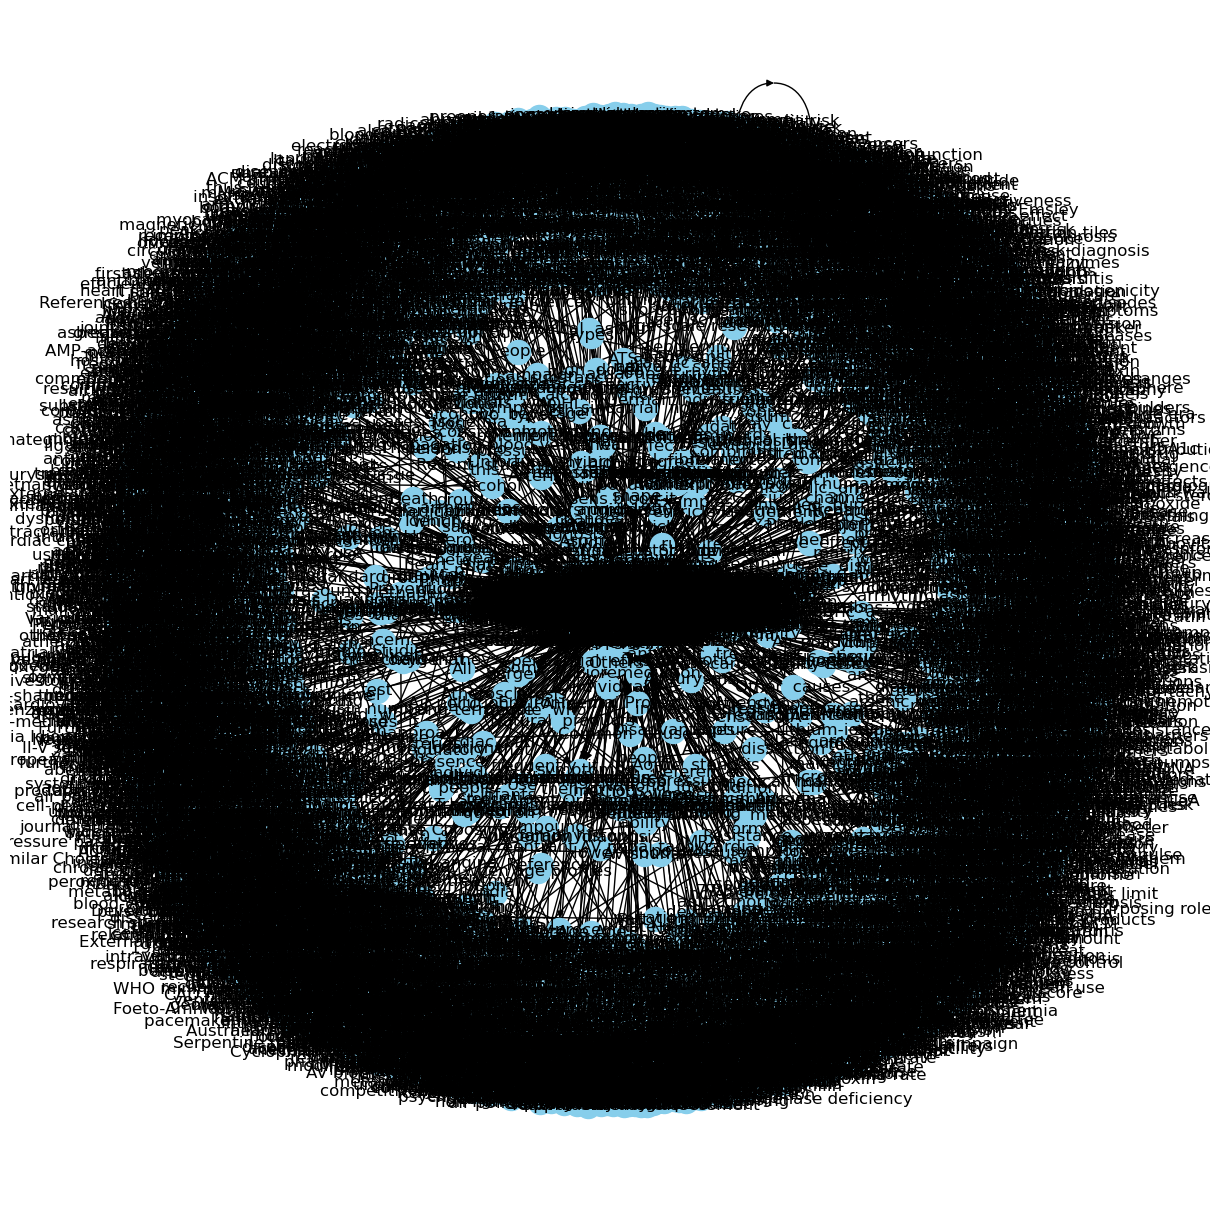

In [70]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

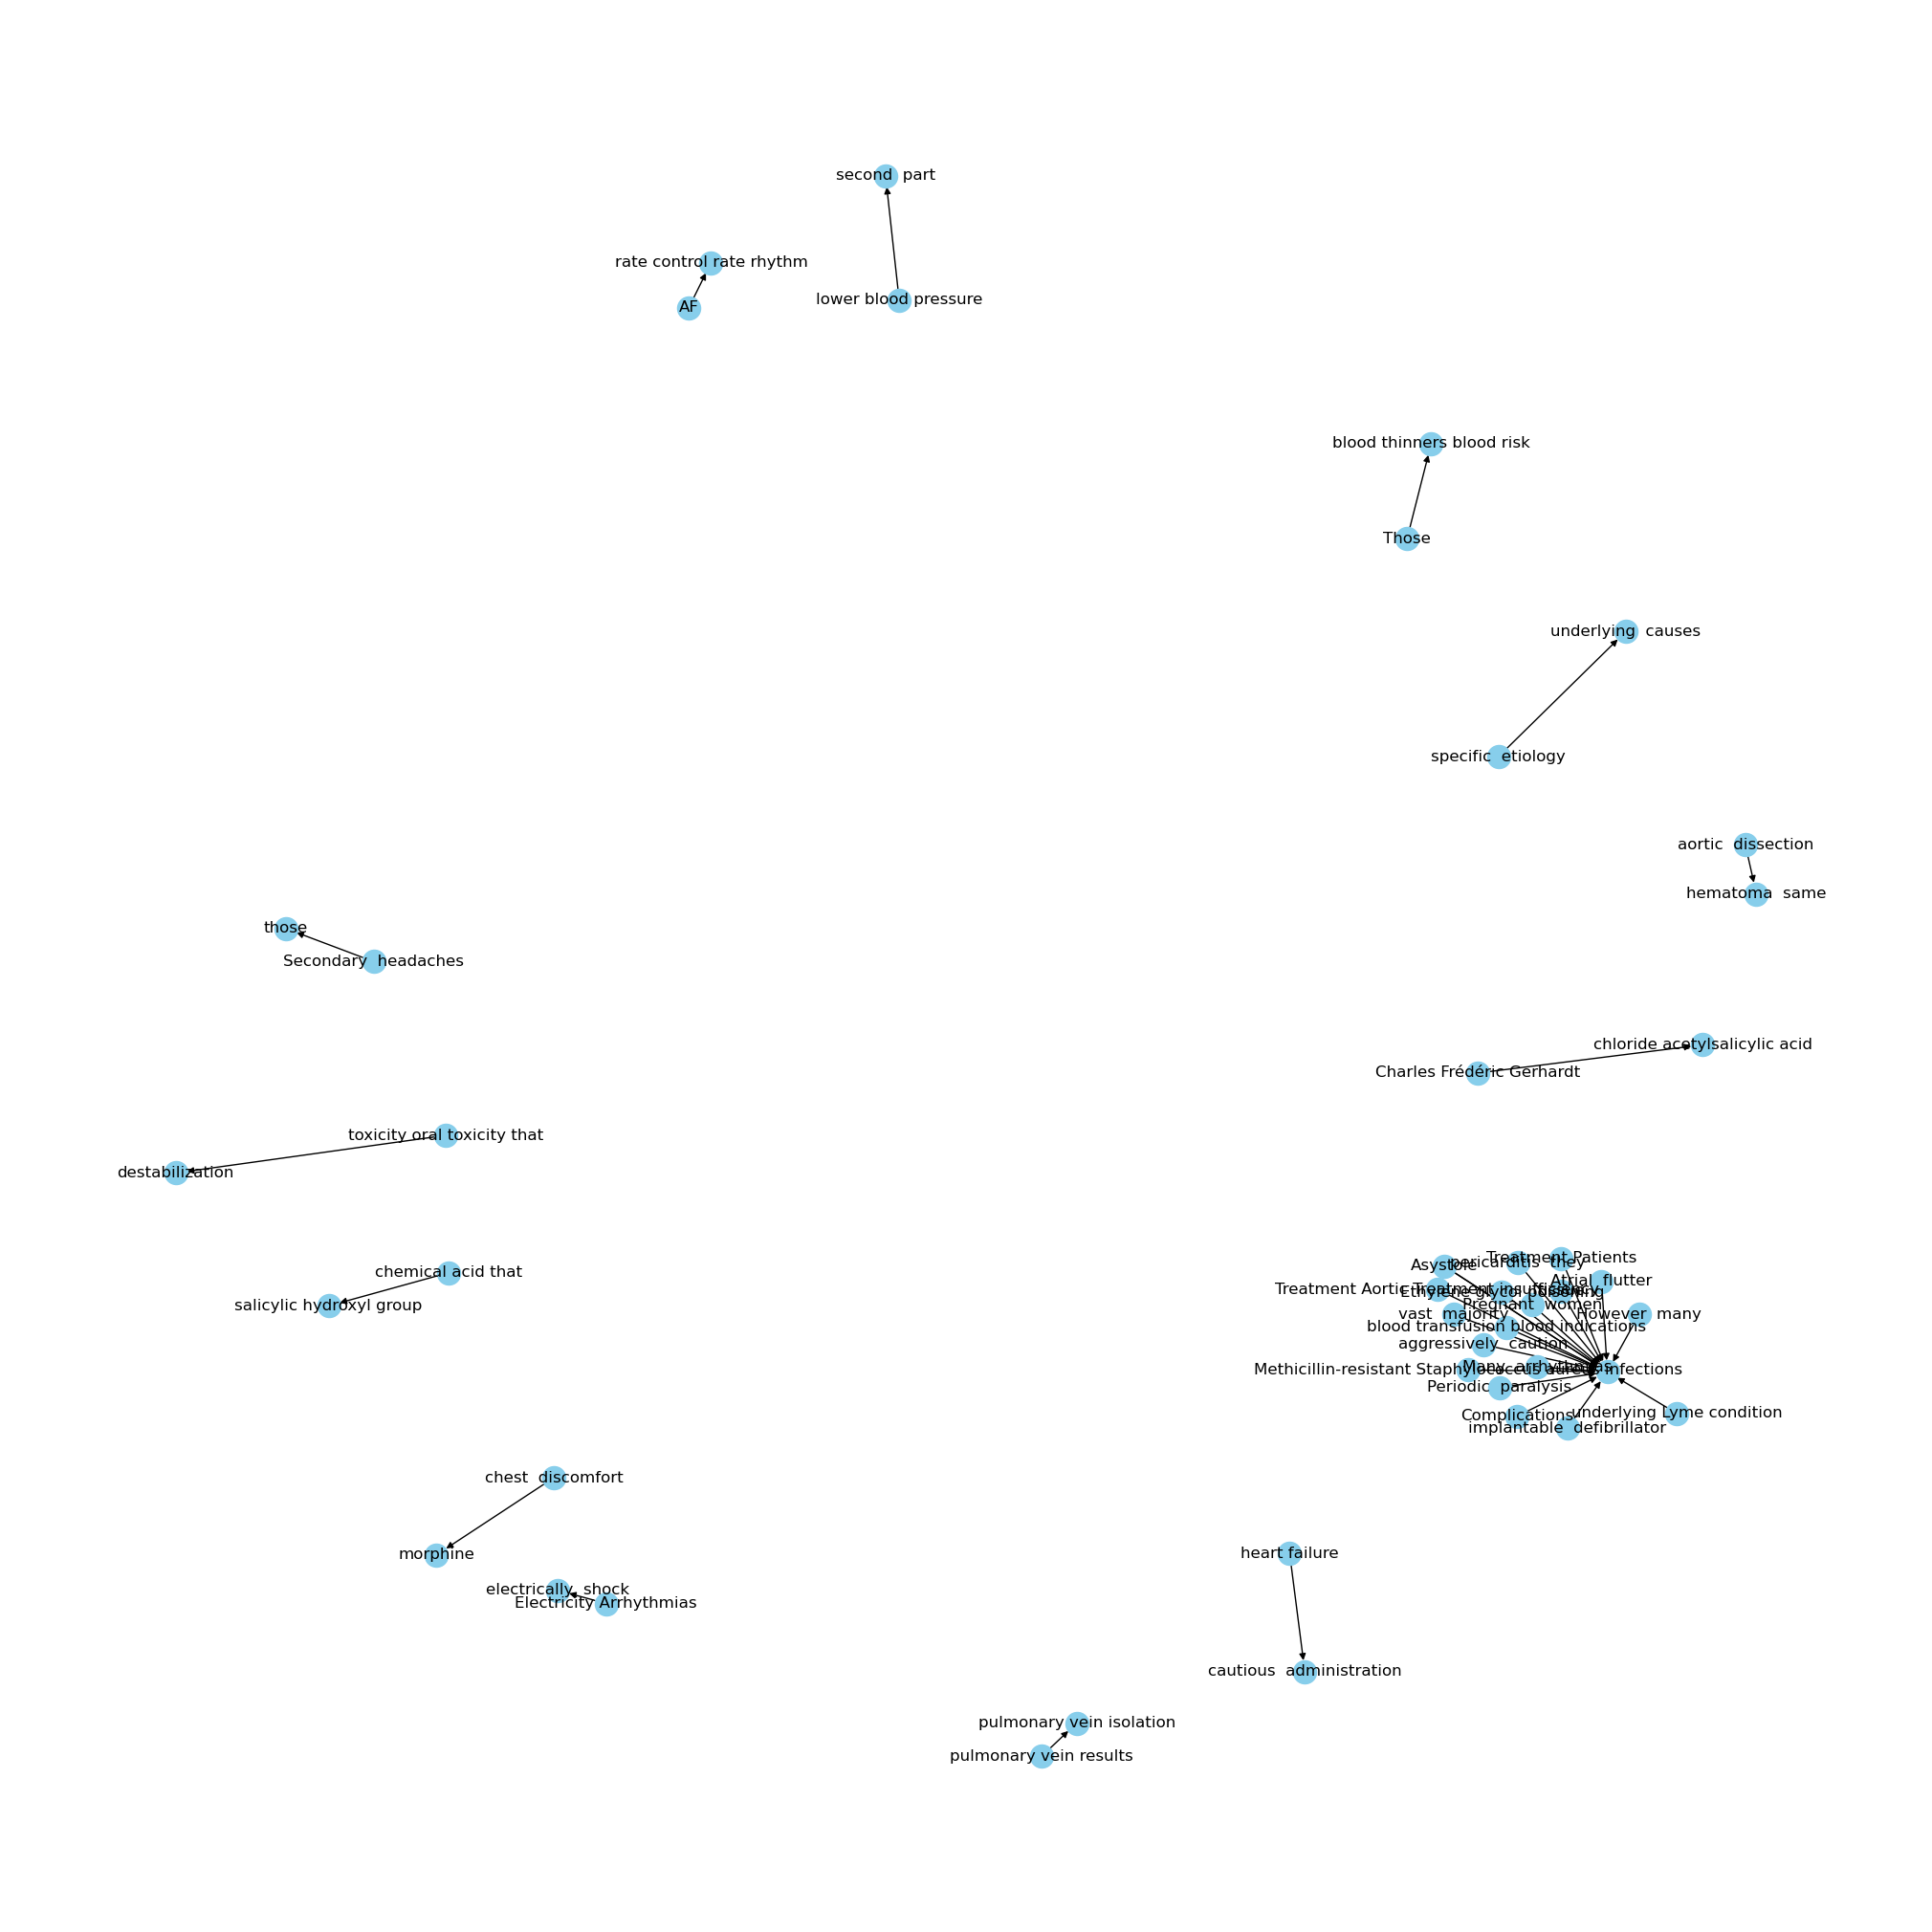

In [80]:
G_1=nx.from_pandas_edgelist(df[df['relation']=='treated'], "ent1", "ent2", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G_1)
nx.draw(G_1, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Reds, pos = pos)
plt.show()